spatial model vs logistic (stochastic and deterministic)

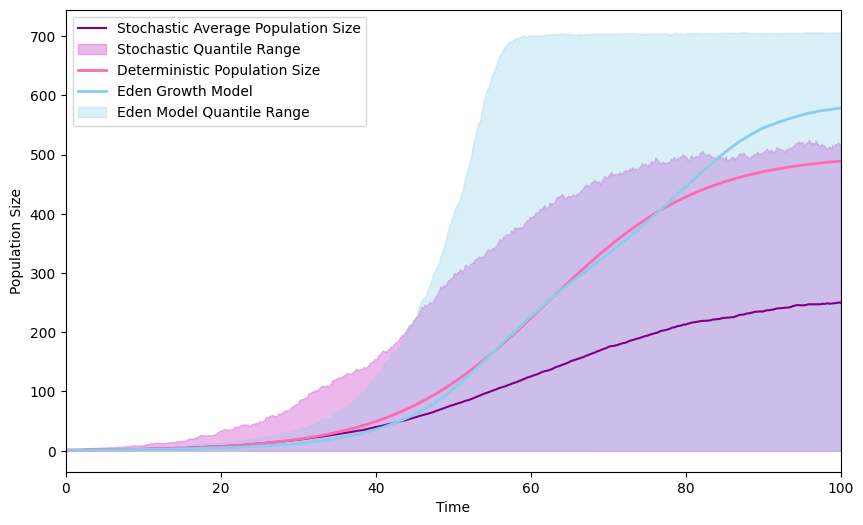

Extinction Probability: 0.48
Eden Model Extinction Rate: 17.00%


In [7]:
import numpy as np
import matplotlib.pyplot as plt
 
# Logistic growth models parameters and functions
def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, competition_coefficient=0.01, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity) + params['death_rate'] * (population / carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate * population + effective_birth_rate * population))
        
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1
    
    max_len = max(len(sim) for sim in all_population_sizes)
    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.nanquantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.nanquantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def deterministic_logistic_growth(P0, r, K, t):
    return K / (1 + ((K - P0) / P0) * np.exp(-r * t))

def run_multiple_deterministic_simulations(P0, r, K, t_points, num_simulations=100):
    all_population_sizes = []
    
    for _ in range(num_simulations):
        P_t = deterministic_logistic_growth(P0, r, K, t_points)
        all_population_sizes.append(P_t)
    
    return all_population_sizes

# Eden Growth Model functions
def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1
    return grid, set([(center, center)]), set([(center, center)])

def get_moore_neighborhood(x, y, size):
    neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
                 (x + 1, y + 1), (x - 1, y - 1), (x + 1, y - 1), (x - 1, y + 1)]
    return [(nx, ny) for nx, ny in neighbors if 0 <= nx < size and 0 <= ny < size]

def draw_circular_wall(grid, size, radius):
    center = size // 2
    for x in range(size):
        for y in range(size):
            if (x - center) ** 2 + (y - center) ** 2 > radius ** 2:
                grid[x, y] = -1  # Use -1 to indicate the wall
    return grid

def grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob, radius):
    size = len(grid)
    population_size = [1]
    time_points = [0]

    center = size // 2

    def is_within_circle(x, y):
        return (x - center) ** 2 + (y - center) ** 2 <= radius ** 2

    for _ in range(iterations):
        if not border:
            break

        N = np.sum(grid > 0)  # Only count actual cells, not walls
        num_dividing_cells = len(dividing_cells)

        summed_death = base_death_prob * N
        summed_birth = base_growth_rate * num_dividing_cells

        total_rate = summed_death + summed_birth
        if total_rate == 0:
            break

        if np.random.rand() < summed_birth / total_rate:
            new_site = list(border)[np.random.randint(len(border))]
            if is_within_circle(new_site[0], new_site[1]):
                grid[new_site] = 1
                border.remove(new_site)

                # Update border
                for nx, ny in get_moore_neighborhood(*new_site, size):
                    if grid[nx, ny] == 0 and is_within_circle(nx, ny):
                        border.add((nx, ny))

                    if grid[nx, ny] == 1 and is_within_circle(nx, ny):
                        if not all(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)):
                            dividing_cells.add((nx, ny))
                        elif ((nx, ny) in dividing_cells):
                            dividing_cells.remove((nx, ny))

                if not all(grid[nx, ny] == 1 for nx, ny in get_moore_neighborhood(*new_site, size)):
                    dividing_cells.add(new_site)
                        
                border = set(border)
                dividing_cells = set(dividing_cells)
        else:
            living_cells = np.argwhere(grid == 1).tolist()
            if living_cells:
                death_site = tuple(living_cells[np.random.randint(len(living_cells))])
                grid[death_site] = 0
                
                if death_site in dividing_cells:
                    dividing_cells.remove(death_site)

                # Update border and dividing_cells for death_site
                for nx, ny in get_moore_neighborhood(*death_site, size):
                    if grid[nx, ny] == 1 and is_within_circle(nx, ny):
                        dividing_cells.add((nx, ny))
                
                    if is_within_circle(nx, ny) and grid[nx, ny] == 0:
                        if any(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)):
                            border.add((nx, ny))
                        elif (nx, ny) in border:
                            border.remove((nx, ny))
                
                if any(grid[nx, ny] == 1 for nx, ny in get_moore_neighborhood(*death_site, size)):
                    if is_within_circle(death_site[0], death_site[1]):
                        border.add(death_site)

                border = set(border)
                dividing_cells = set(dividing_cells)
            
            else:
                print("false")
        
        next_event_time = np.random.exponential(1 / total_rate)
        time_points.append(time_points[-1] + next_event_time)

        population_size.append(np.sum(grid > 0))

    return grid, population_size, time_points

# Function to plot combined results
def plot_combined_models(average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, average_population_sizes_deterministic, t_points, eden_time_points, eden_mean_population_size, eden_quantiles_5, eden_quantiles_95):
    plt.figure(figsize=(10, 6))

    plt.plot(average_time_points, average_population_sizes_stochastic, color='purple', linestyle='-', label='Stochastic Average Population Size')
    plt.fill_between(average_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Stochastic Quantile Range')
    
    plt.plot(t_points, average_population_sizes_deterministic, color='hotpink', linestyle='-', linewidth=2, label='Deterministic Population Size')

    # Add the Eden Growth Model
    plt.plot(eden_time_points, eden_mean_population_size, color='skyblue', linestyle='-', linewidth=2, label='Eden Growth Model')
    plt.fill_between(eden_time_points, eden_quantiles_5, eden_quantiles_95, color='skyblue', alpha=0.3, label='Eden Model Quantile Range')
    plt.xlim(0,100)
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.legend(loc='upper left')
    plt.show()

# Run the Eden Growth Model
grid_size = 100
iterations = 2000
base_growth_rate = 0.1
base_death_prob = 0.01
num_simulations = 100
radius = 15

all_population_sizes = []
all_time_points = []
extinction_count = 0

for _ in range(num_simulations):
    grid, border, dividing_cells = initialize_grid(grid_size)
    grid = draw_circular_wall(grid, grid_size, radius)
    grid, population_size, time_points = grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob, radius)

    if population_size[-1] == 0:
        extinction_count += 1

    all_population_sizes.append(np.interp(np.linspace(0, max(time_points), iterations), time_points, population_size))
    all_time_points.append(np.linspace(0, max(time_points), iterations))

all_population_sizes = np.array(all_population_sizes)
time_points = np.mean(all_time_points, axis=0)

quantiles_5 = np.percentile(all_population_sizes, 5, axis=0)
quantiles_95 = np.percentile(all_population_sizes, 95, axis=0)
mean_population_size = np.mean(all_population_sizes, axis=0)

extinction_rate = (extinction_count / num_simulations) * 100

# Parameters for stochastic model
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Multiple stochastic simulations
average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations)

# Parameters for deterministic model
P0 = 1  # Initial population size
r = 0.1  # Growth rate
K = 500  # Carrying capacity
t_max = 100  # Maximum time
t_points = np.linspace(0, t_max, 500)  # Time points

# Multiple deterministic simulations
average_population_sizes_deterministic = np.mean(run_multiple_deterministic_simulations(P0, r, K, t_points, num_simulations), axis=0)

# Plot the combined models including the Eden Growth Model
plot_combined_models(average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, average_population_sizes_deterministic, t_points, time_points, mean_population_size, quantiles_5, quantiles_95)

# Print extinction probability
print(f"Extinction Probability: {extinction_probability:.2f}")
print(f"Eden Model Extinction Rate: {extinction_rate:.2f}%")


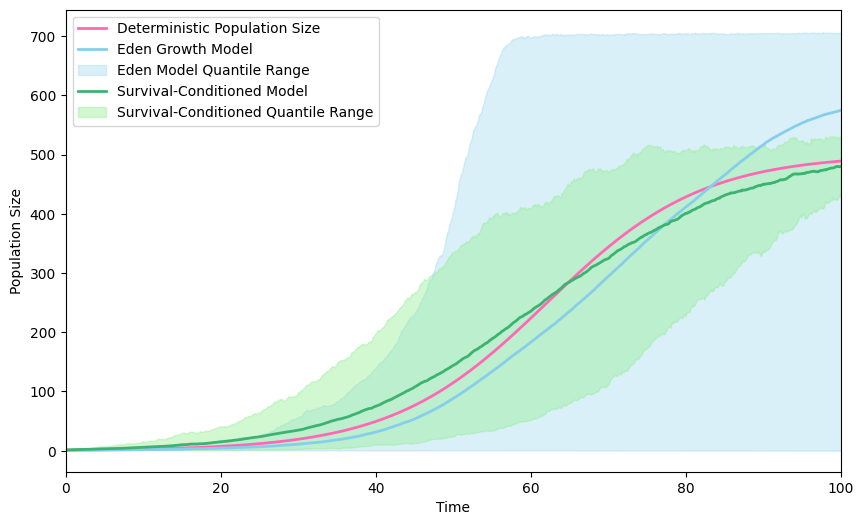

Eden Model Extinction Rate: 17.00%


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Define functions for the survival-conditioned logistic growth model
def set_parameters_survival(initial_population=50, birth_rate=0.1, death_rate=0.1, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation_survival(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']

    time_points = [0]
    population_sizes = [population]

    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = birth_rate * (1 - population / carrying_capacity) + death_rate * (population / carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate * population + effective_birth_rate * population))
        
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1

        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)

    return time_points, population_sizes

def run_multiple_simulations_with_quantiles_survival(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']

    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation_survival(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1

    max_len = max(len(sim) for sim in all_time_points)
    num_points = max_len
    average_time_points = np.linspace(0, max_time, num_points)

    non_extinct_populations = [pop for pop in all_population_sizes if pop[-1] > 0]
    non_extinct_times = [time for time, pop in zip(all_time_points, all_population_sizes) if pop[-1] > 0]
    non_extinct_interpolations = np.zeros((len(non_extinct_populations), num_points))

    for i, (time, pop) in enumerate(zip(non_extinct_times, non_extinct_populations)):
        non_extinct_interpolations[i] = np.interp(average_time_points, time, pop)

    average_population_sizes = np.mean(non_extinct_interpolations, axis=0)
    lower_quantile = np.nanquantile(non_extinct_interpolations, 0.05, axis=0)
    upper_quantile = np.nanquantile(non_extinct_interpolations, 0.95, axis=0)

    extinction_probability = extinction_count / num_simulations

    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

# Logistic growth models parameters and functions
def set_parameters(initial_population=50, birth_rate=0.1, death_rate=0.1, competition_coefficient=0.01, carrying_capacity=500, max_time=100):
    return {
        'initial_population': initial_population,
        'birth_rate': birth_rate,
        'death_rate': death_rate,
        'carrying_capacity': carrying_capacity,
        'max_time': max_time
    }

def run_simulation(params):
    population = params['initial_population']
    birth_rate = params['birth_rate']
    death_rate = params['death_rate']
    max_time = params['max_time']
    carrying_capacity = params['carrying_capacity']
    
    time_points = [0]
    population_sizes = [population]
    
    while population > 0 and time_points[-1] < max_time:
        effective_birth_rate = params['birth_rate'] * (1 - population / carrying_capacity) + params['death_rate'] * (population / carrying_capacity)
        next_event_time = np.random.exponential(1 / (death_rate * population + effective_birth_rate * population))
        
        if np.random.rand() < effective_birth_rate / (effective_birth_rate + death_rate):
            population += 1
        else:
            population -= 1
        
        time_points.append(time_points[-1] + next_event_time)
        population_sizes.append(population)
    
    return time_points, population_sizes

def run_multiple_simulations_with_quantiles(params, num_simulations=100):
    all_time_points = []
    all_population_sizes = []
    extinction_count = 0
    max_time = params['max_time']
    
    for _ in range(num_simulations):
        time_points, population_sizes = run_simulation(params)
        all_time_points.append(time_points)
        all_population_sizes.append(population_sizes)
        if population_sizes[-1] == 0:
            extinction_count += 1
    
    max_len = max(len(sim) for sim in all_population_sizes)
    num_points = 1000
    average_time_points = np.linspace(0, max_time, num_points)
    interpolated_populations = np.zeros((num_simulations, num_points))
    for i in range(num_simulations):
        interpolated_populations[i] = np.interp(average_time_points, all_time_points[i], all_population_sizes[i])
    average_population_sizes = np.mean(interpolated_populations, axis=0)
    lower_quantile = np.nanquantile(interpolated_populations, 0.05, axis=0)
    upper_quantile = np.nanquantile(interpolated_populations, 0.95, axis=0)
    
    extinction_probability = extinction_count / num_simulations
    
    return average_time_points, average_population_sizes, lower_quantile, upper_quantile, extinction_probability

def deterministic_logistic_growth(P0, r, K, t):
    return K / (1 + ((K - P0) / P0) * np.exp(-r * t))

def run_multiple_deterministic_simulations(P0, r, K, t_points, num_simulations=100):
    all_population_sizes = []
    
    for _ in range(num_simulations):
        P_t = deterministic_logistic_growth(P0, r, K, t_points)
        all_population_sizes.append(P_t)
    
    return all_population_sizes

# Eden Growth Model functions
def initialize_grid(size):
    grid = np.zeros((size, size), dtype=int)
    center = size // 2
    grid[center, center] = 1
    return grid, set([(center, center)]), set([(center, center)])

def get_moore_neighborhood(x, y, size):
    neighbors = [(x + 1, y), (x - 1, y), (x, y + 1), (x, y - 1),
                 (x + 1, y + 1), (x - 1, y - 1), (x + 1, y - 1), (x - 1, y + 1)]
    return [(nx, ny) for nx, ny in neighbors if 0 <= nx < size and 0 <= ny < size]

def draw_circular_wall(grid, size, radius):
    center = size // 2
    for x in range(size):
        for y in range(size):
            if (x - center) ** 2 + (y - center) ** 2 > radius ** 2:
                grid[x, y] = -1  # Use -1 to indicate the wall
    return grid

def grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob, radius):
    size = len(grid)
    population_size = [1]
    time_points = [0]

    center = size // 2

    def is_within_circle(x, y):
        return (x - center) ** 2 + (y - center) ** 2 <= radius ** 2

    for _ in range(iterations):
        if not border:
            break

        N = np.sum(grid > 0)  # Only count actual cells, not walls
        num_dividing_cells = len(dividing_cells)

        summed_death = base_death_prob * N
        summed_birth = base_growth_rate * num_dividing_cells

        total_rate = summed_death + summed_birth
        if total_rate == 0:
            break

        if np.random.rand() < summed_birth / total_rate:
            new_site = list(border)[np.random.randint(len(border))]
            if is_within_circle(new_site[0], new_site[1]):
                grid[new_site] = 1
                border.remove(new_site)

                # Update border
                for nx, ny in get_moore_neighborhood(*new_site, size):
                    if grid[nx, ny] == 0 and is_within_circle(nx, ny):
                        border.add((nx, ny))

                    if grid[nx, ny] == 1 and is_within_circle(nx, ny):
                        if not all(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)):
                            dividing_cells.add((nx, ny))
                        elif ((nx, ny) in dividing_cells):
                            dividing_cells.remove((nx, ny))

                if not all(grid[nx, ny] == 1 for nx, ny in get_moore_neighborhood(*new_site, size)):
                    dividing_cells.add(new_site)
                        
                border = set(border)
                dividing_cells = set(dividing_cells)
        else:
            living_cells = np.argwhere(grid == 1).tolist()
            if living_cells:
                death_site = tuple(living_cells[np.random.randint(len(living_cells))])
                grid[death_site] = 0
                
                if death_site in dividing_cells:
                    dividing_cells.remove(death_site)

                # Update border and dividing_cells for death_site
                for nx, ny in get_moore_neighborhood(*death_site, size):
                    if grid[nx, ny] == 1 and is_within_circle(nx, ny):
                        dividing_cells.add((nx, ny))
                
                    if is_within_circle(nx, ny) and grid[nx, ny] == 0:
                        if any(grid[nxx, nyy] == 1 for nxx, nyy in get_moore_neighborhood(nx, ny, size) if is_within_circle(nxx, nyy)):
                            border.add((nx, ny))
                        elif (nx, ny) in border:
                            border.remove((nx, ny))
                
                if any(grid[nx, ny] == 1 for nx, ny in get_moore_neighborhood(*death_site, size)):
                    if is_within_circle(death_site[0], death_site[1]):
                        border.add(death_site)

                border = set(border)
                dividing_cells = set(dividing_cells)
            
            else:
                print("false")
        
        next_event_time = np.random.exponential(1 / total_rate)
        time_points.append(time_points[-1] + next_event_time)

        population_size.append(np.sum(grid > 0))

    return grid, population_size, time_points

# Function to interpolate the population sizes to match the common time points
def interpolate_population_sizes(time_points, population_sizes, target_time_points):
    interpolation_function = interp1d(time_points, population_sizes, kind='linear', fill_value="extrapolate")
    interpolated_population_sizes = interpolation_function(target_time_points)
    return interpolated_population_sizes

# Function to plot combined results including the survival-conditioned logistic growth model
def plot_combined_models(average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, average_population_sizes_deterministic, t_points, eden_time_points, eden_mean_population_size, eden_quantiles_5, eden_quantiles_95, average_population_sizes_survival, lower_quantile_survival, upper_quantile_survival):
    plt.figure(figsize=(10, 6))

    # Stochastic model
    # plt.plot(average_time_points, average_population_sizes_stochastic, color='purple', linestyle='-', label='Stochastic Average Population Size')
    # plt.fill_between(average_time_points, lower_quantile, upper_quantile, color='orchid', alpha=0.5, label='Stochastic Quantile Range')
    
    # Deterministic model
    plt.plot(t_points, average_population_sizes_deterministic, color='hotpink', linestyle='-', linewidth=2, label='Deterministic Population Size')

    # Eden Growth Model
    plt.plot(eden_time_points, eden_mean_population_size, color='skyblue', linestyle='-', linewidth=2, label='Eden Growth Model')
    plt.fill_between(eden_time_points, eden_quantiles_5, eden_quantiles_95, color='skyblue', alpha=0.3, label='Eden Model Quantile Range')

    # Survival-conditioned logistic growth model
    plt.plot(average_time_points, average_population_sizes_survival, color='mediumseagreen', linestyle='-', linewidth=2, label='Survival-Conditioned Model')
    plt.fill_between(average_time_points, lower_quantile_survival, upper_quantile_survival, color='lightgreen', alpha=0.4, label='Survival-Conditioned Quantile Range')

    plt.xlim(0, 100)
    plt.xlabel('Time')
    plt.ylabel('Population Size')
    plt.legend(loc='upper left')
    plt.show()

# Run the Eden Growth Model
grid_size = 100
iterations = 2000
base_growth_rate = 0.1
base_death_prob = 0.01
num_simulations = 100
radius = 15

all_population_sizes = []
all_time_points = []
extinction_count = 0

for _ in range(num_simulations):
    grid, border, dividing_cells = initialize_grid(grid_size)
    grid = draw_circular_wall(grid, grid_size, radius)
    grid, population_size, time_points = grow_cluster(grid, border, dividing_cells, iterations, base_growth_rate, base_death_prob, radius)

    if population_size[-1] == 0:
        extinction_count += 1

    all_population_sizes.append(np.interp(np.linspace(0, max(time_points), iterations), time_points, population_size))
    all_time_points.append(np.linspace(0, max(time_points), iterations))

all_population_sizes = np.array(all_population_sizes)
time_points = np.mean(all_time_points, axis=0)

quantiles_5 = np.percentile(all_population_sizes, 5, axis=0)
quantiles_95 = np.percentile(all_population_sizes, 95, axis=0)
mean_population_size = np.mean(all_population_sizes, axis=0)

extinction_rate = (extinction_count / num_simulations) * 100

# Parameters for stochastic model
params = set_parameters(initial_population=1, birth_rate=0.2, death_rate=0.1)

# Multiple stochastic simulations
average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile, extinction_probability = run_multiple_simulations_with_quantiles(params, num_simulations)

# Parameters for deterministic model
P0 = 1  # Initial population size
r = 0.1  # Growth rate
K = 500  # Carrying capacity
t_max = 100  # Maximum time
t_points = np.linspace(0, t_max, 500)  # Time points

# Multiple deterministic simulations
average_population_sizes_deterministic = np.mean(run_multiple_deterministic_simulations(P0, r, K, t_points, num_simulations), axis=0)

# Run survival-conditioned model
params_survival = set_parameters_survival(initial_population=1, birth_rate=0.2, death_rate=0.1)
average_time_points_survival, average_population_sizes_survival, lower_quantile_survival, upper_quantile_survival, extinction_probability_survival = run_multiple_simulations_with_quantiles_survival(params_survival, num_simulations)

# Interpolate the survival-conditioned model's results to match the average_time_points
average_population_sizes_survival_interp = interpolate_population_sizes(average_time_points_survival, average_population_sizes_survival, average_time_points)
lower_quantile_survival_interp = interpolate_population_sizes(average_time_points_survival, lower_quantile_survival, average_time_points)
upper_quantile_survival_interp = interpolate_population_sizes(average_time_points_survival, upper_quantile_survival, average_time_points)

# Plot the combined models including the Survival-Conditioned Logistic Growth Model
plot_combined_models(
    average_time_points, average_population_sizes_stochastic, lower_quantile, upper_quantile,
    average_population_sizes_deterministic, t_points,
    time_points, mean_population_size, quantiles_5, quantiles_95,
    average_population_sizes_survival_interp, lower_quantile_survival_interp, upper_quantile_survival_interp
)

# Print extinction probabilities
#print(f"Stochastic Model Extinction Probability: {extinction_probability:.2f}")
print(f"Eden Model Extinction Rate: {extinction_rate:.2f}%")
#print(f"Survival-Conditioned Model Extinction Probability: {extinction_probability_survival:.2f}")
